In [2]:
#note: uses hack conda env
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix, classification_report, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
import pickle
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
import matplotlib as plt
from sklearn.manifold import MDS
import warnings
warnings.filterwarnings('ignore')

/opt/homebrew/Caskroom/miniforge/base/envs/hack/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Null Entries in Each Column:
id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64
num neighbourhood groups: 5
num neighbourhoods: 221
is null: 0
                   latitude  longitude     price  minimum_nights  \
latitude           1.000000   0.084788  0.033939        0.024869   
longitude          0.084788   1.000000 -0.150019       -0.062747   
price              0.033939  -0.150019  1.000000   

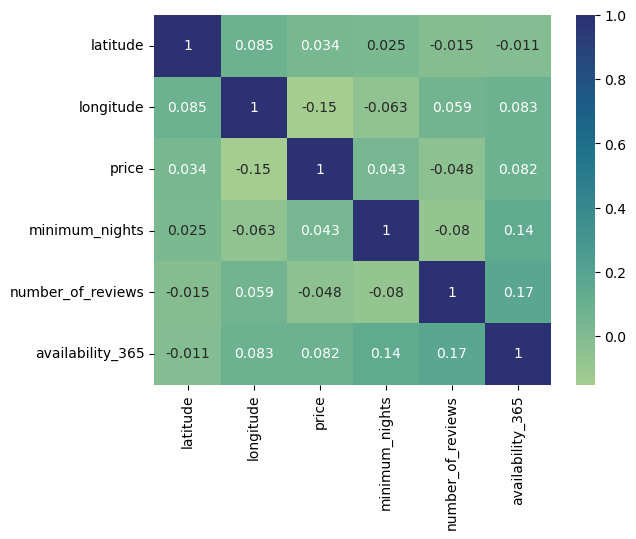

(48895, 235)


In [3]:
raw_data = house_data = pd.read_csv('nyc_2019_data.csv')
print("Null Entries in Each Column:")
print(raw_data.isnull().sum())

# potential columns to use: neighbourhood_group, neighorbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, reviews_per_month, availability_365
raw_data = raw_data[['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'availability_365']]
print("num neighbourhood groups: " + str(raw_data['neighbourhood_group'].nunique()))
print("num neighbourhoods: " + str(raw_data['neighbourhood'].nunique()))

# corr_data = pd.read_csv('nyc_2019_data.csv', low_memory=False)
corr_data= raw_data[['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'availability_365']]
for col in corr_data.columns:
    null_column = int(corr_data[col].isna().sum())
    if (null_column > 0):
        print(str(col) + " null: " + str(null_column))
print("is null: " + str(corr_data.isnull().sum().sum()))
res= corr_data.corr()
print(res)
sns.heatmap(res, annot=True, cmap="crest")
plt.pyplot.show()


# one hot encoding categorical variables
neighbourhood = pd.get_dummies(raw_data[['neighbourhood_group', 'room_type', 'neighbourhood']])
raw_data = raw_data.drop(columns=['neighbourhood_group', 'room_type', 'neighbourhood'])
raw_data = pd.concat([raw_data, neighbourhood],axis=1)

print(raw_data.shape)

In [196]:
y_data = raw_data['price']
x_data = raw_data.drop(columns=['price'])
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

print("x_train shape: " + str(x_train.shape))
print("y_train shape: " + str(y_train.shape))
print("x_test shape: " + str(x_test.shape))
print("y_test shape: " + str(y_test.shape))

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# standarizing each feature using the training data to have a mean=0 and SD=1 to provide a more stable model and fast training
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

x_train shape: (39116, 234)
y_train shape: (39116,)
x_test shape: (9779, 234)
y_test shape: (9779,)


In [197]:
# Linear Regression Model - Closed Form Solution

reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
print("average price in testing data: " + str(float(np.average(y_test))))
root_mean_squared_error = np.sqrt(mean_squared_error(y_test, y_pred))
r2_score_1 = r2_score(y_test, y_pred)
print("root mean squared error (Linear Regression): " + str(root_mean_squared_error))
print("r_2 score linear regression: " + str(r2_score_1))


average price in testing data: 150.59402801922488
root mean squared error (Linear Regression): 420302936289073.5
r_2 score linear regression: -4.5743929991781987e+24


alpha: 0
rsme :700035781219436.0
r2_score: -1.2689634198650158e+25

alpha: 1
rsme :180.52588305789897
r2_score: 0.15610661740192555

alpha: 2
rsme :180.52588974166275
r2_score: 0.15610655491355485



Text(0.5, 1.0, 'RSME vs Alpha')

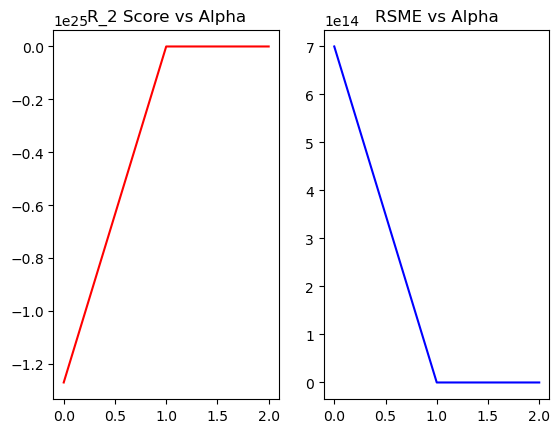

In [226]:
# Ridge Regression : alpha = strength of L2 regularized term (increases bias to reduce potential overfitting)
# very small alpha value signficantly improves the model to ensure a positive r2_score and significantly lower RSME
# but the model is still performing overall very poorly

r2_scores_list = []
root_mean_squared_error_list = []
alpha_list = []

for i in range(0, 3):
    alpha_list.append(i)
    ridge = Ridge(alpha=i)
    ridge.fit(x_train, y_train)
    y_pred = ridge.predict(x_test)
    root_mean_squared_error = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_score_1 = r2_score(y_test, y_pred)
    root_mean_squared_error_list.append(float(root_mean_squared_error))
    r2_scores_list.append(float(r2_score_1))
    print("alpha: " + str(i))
    print("rmse :" + str(float(root_mean_squared_error)))
    print("r2_score: " + str(float(r2_score_1)))
    print()
figure, axis = plt.pyplot.subplots(1, 2)

axis[0].plot(alpha_list, r2_scores_list, color='red')
axis[0].set_title('R_2 Score vs Alpha')
axis[1].plot(alpha_list, root_mean_squared_error_list, color='blue')
axis[1].set_title('RMSE vs Alpha')


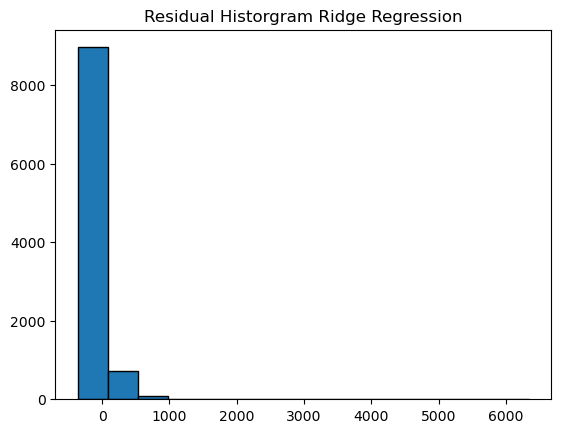

In [240]:
# Historgram Shows that Residual Plot is Sckewed to the Right
ridge = Ridge(alpha=1)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)
residual = y_test - y_pred
plt.pyplot.hist(residual, bins=15, edgecolor='black')
plt.pyplot.title('Residual Historgram Ridge Regression')
plt.pyplot.show()

In [28]:
# Use Log Transformation to make Residual Distribution Normal

raw_data = house_data = pd.read_csv('nyc_2019_data.csv')
raw_data = raw_data[['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'availability_365']]

neighbourhood = pd.get_dummies(raw_data[['neighbourhood_group', 'room_type', 'neighbourhood']])
raw_data = raw_data.drop(columns=['neighbourhood_group', 'room_type', 'neighbourhood'])
raw_data = pd.concat([raw_data, neighbourhood],axis=1)

y_data = raw_data['price']
# y_untransformed_data = raw_data['price']
# y_data_1 = np.log(y_data + 1)
# y_data[:] = y_data_1

x_data = raw_data.drop(columns=['price'])

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
y_test_untrans = y_test.to_numpy()
y_train = np.log(y_train.to_numpy() + 1)
y_test = np.log(y_test.to_numpy() + 1)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

Lin Reg Average Price (transformed) in Testing Data: 4.737929045417817
RMSE (transformed): 221028152372.6525
R2 Score Lin Reg: -9.98878813058365e+22
Ridge Reg (alpha=1) Avg. Price (transformed) in Testing data: 4.737929045417817
RMSE (transformed): 0.48237003542454604
R2 Score Ridge Reg: 0.5242505898425516


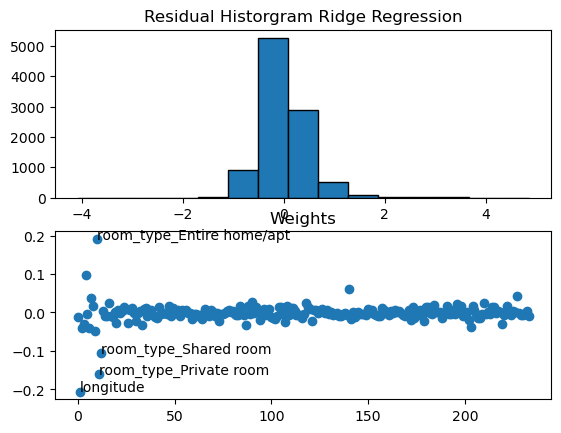

In [30]:
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
print("Lin Reg Average Price (transformed) in Testing Data: " + str(float(np.average(y_train))))
root_mean_squared_error = np.sqrt(mean_squared_error(y_test, y_pred))
r2_score_1 = r2_score(y_test, y_pred)
print("RMSE (transformed): " + str(root_mean_squared_error))
print("R2 Score Lin Reg: " + str(r2_score_1))

ridge = Ridge(alpha=1)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)
print("Ridge Reg (alpha=1) Avg. Price (transformed) in Testing data: " + str(float(np.average(y_train))))
root_mean_squared_error = np.sqrt(mean_squared_error(y_test, y_pred))
r2_score_1 = r2_score(y_test, y_pred)
print("RMSE (transformed): " + str(root_mean_squared_error))
print("R2 Score Ridge Reg: " + str(r2_score_1))

# Historgram Shows that Residual Plot is Sckewed to the Right
figure, axis = plt.pyplot.subplots(2, 1)
residual = y_test - y_pred
axis[0].hist(residual, bins=15, edgecolor='black')
axis[0].set_title('Residual Historgram Ridge Regression')

x_plot = np.arange(0, ridge.coef_.shape[0], 1)
axis[1].scatter(x_plot, ridge.coef_)
axis[1].set_title('Weights')
for i, txt in enumerate(x_data.columns):
    if (ridge.coef_[i] > 0.1 or ridge.coef_[i] < -0.1):
        axis[1].annotate(txt, (x_plot[i], ridge.coef_[i]))



Text(0.5, 1.0, 'RMSE vs Epochs')

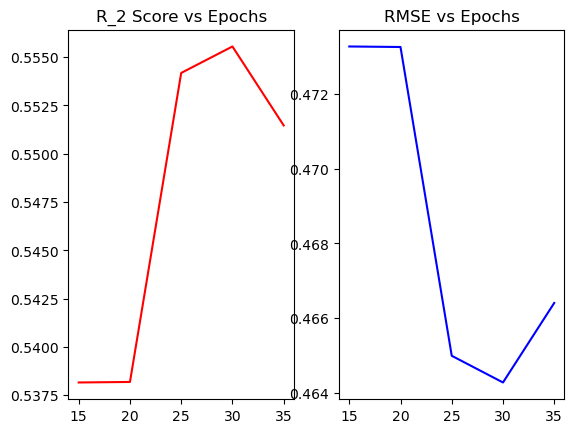

In [7]:
# using neural network with log transformed price with learning rate=0.005
num_epochs = [15, 20, 25, 30, 35]
r2_list = []
rmse_list = []
for epoch in num_epochs:
    nn = MLPRegressor(hidden_layer_sizes=(256, 64, 32), activation="relu", solver='adam', max_iter=epoch, batch_size=32, learning_rate_init=0.005)
    nn.fit(x_train, y_train)
    y_pred = nn.predict(x_test)
    r2_list.append(float(r2_score(y_test, y_pred)))
    rmse_list.append(float(np.sqrt(mean_squared_error(y_test, y_pred))))

figure, axis = plt.pyplot.subplots(1, 2)
axis[0].plot(num_epochs, r2_list, color='red')
axis[0].set_title('R_2 Score vs Epochs')
axis[1].plot(num_epochs, rmse_list, color='blue')
axis[1].set_title('RMSE vs Epochs')


Text(0.5, 1.0, 'RMSE vs Epochs')

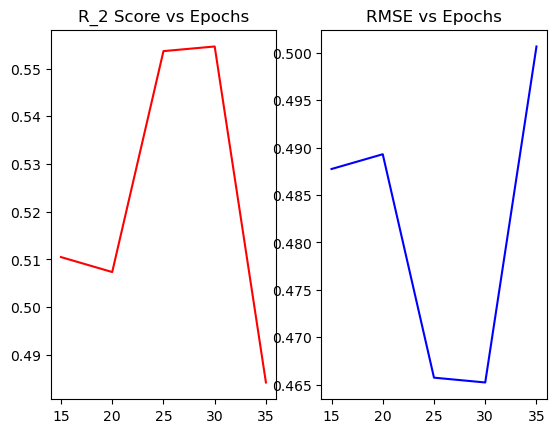

In [12]:
# using neural network with log transformed price with learning rate=0.01
num_epochs = [15, 20, 25, 30, 35]
r2_list = []
rmse_list = []
for epoch in num_epochs:
    nn = MLPRegressor(hidden_layer_sizes=(256, 64, 32), activation="relu", solver='adam', max_iter=epoch, batch_size=32, learning_rate_init=0.01)
    nn.fit(x_train, y_train)
    y_pred = nn.predict(x_test)
    r2_list.append(float(r2_score(y_test, y_pred)))
    rmse_list.append(float(np.sqrt(mean_squared_error(y_test, y_pred))))

figure, axis = plt.pyplot.subplots(1, 2)
axis[0].plot(num_epochs, r2_list, color='red')
axis[0].set_title('R_2 Score vs Epochs')
axis[1].plot(num_epochs, rmse_list, color='blue')
axis[1].set_title('RMSE vs Epochs')

In [27]:
# Best Trained and Tuned Model So Far
nn = MLPRegressor(hidden_layer_sizes=(256, 64, 32), activation="relu", solver='adam', max_iter=30, batch_size=32, learning_rate_init=0.005)
nn.fit(x_train, y_train)
y_pred = nn.predict(x_test)
print("final model r2 score: " + str(float(r2_score(y_test, y_pred))))
print("final model rmse: " + str(float(np.sqrt(mean_squared_error(y_test, y_pred)))))

final model r2 score: 0.5388905846968925
final model rmse: 0.46710437746113403


Ridge Reg (alpha=1) Avg. Price (transformed) in Testing data: 4.737203402071127
RMSE (transformed): 0.47793673814703913
R2 Score Ridge Reg: 0.5300709049654624


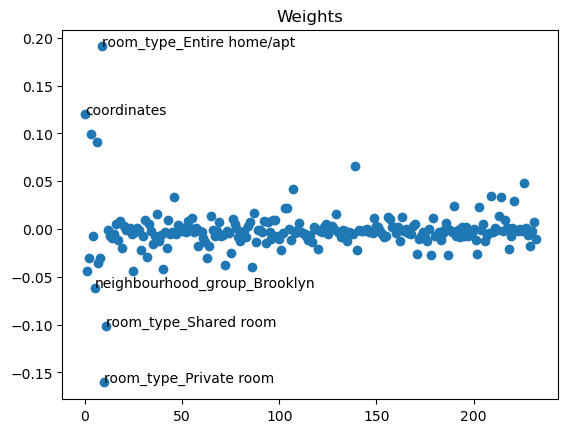

In [4]:
# combine latitude and longitude using PCA for potentially better results
# results show that this change did not improve the R2 Score and RMSE

raw_data = house_data = pd.read_csv('nyc_2019_data.csv')
raw_data = raw_data[['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'availability_365']]

embedding = PCA(n_components=1)
coordinates = embedding.fit_transform(raw_data[['latitude', 'longitude']])
raw_data['latitude'] = coordinates
raw_data = raw_data.rename(columns={'latitude': 'coordinates'})

neighbourhood = pd.get_dummies(raw_data[['neighbourhood_group', 'room_type', 'neighbourhood']])
raw_data = raw_data.drop(columns=['neighbourhood_group', 'room_type', 'neighbourhood', 'longitude'])
raw_data = pd.concat([raw_data, neighbourhood],axis=1)

y_data = raw_data['price']
y_data_1 = np.log(y_data + 1)
y_data[:] = y_data_1

x_data = raw_data.drop(columns=['price'])

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

ridge = Ridge(alpha=1)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)
print("Ridge Reg (alpha=1) Avg. Price (transformed) in Testing data: " + str(float(np.average(y_train))))
root_mean_squared_error = np.sqrt(mean_squared_error(y_test, y_pred))
r2_score_1 = r2_score(y_test, y_pred)
print("RMSE (transformed): " + str(root_mean_squared_error))
print("R2 Score Ridge Reg: " + str(r2_score_1))

figure, axis = plt.pyplot.subplots(1, 1)

x_plot = np.arange(0, ridge.coef_.shape[0], 1)
axis.scatter(x_plot, ridge.coef_)
axis.set_title('Weights')
for i, txt in enumerate(x_data.columns):
    if (ridge.coef_[i] > 0.1 or ridge.coef_[i] < -0.05):
        axis.annotate(txt, (x_plot[i], ridge.coef_[i]))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


Text(0.5, 1.0, 'RMSE vs Epochs')

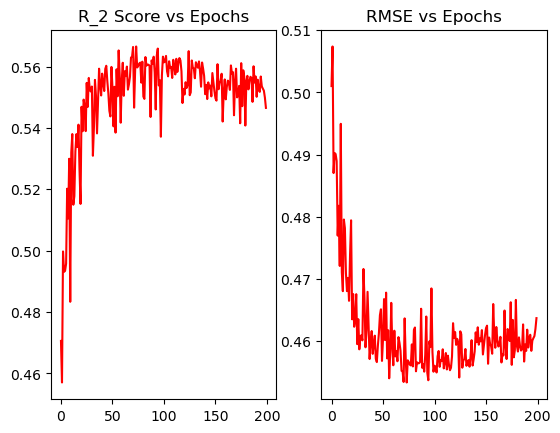

In [5]:
# testing to see if feature cross with latitude and longitude improves accuracy

raw_data = house_data = pd.read_csv('nyc_2019_data.csv')
raw_data = raw_data[['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'availability_365']]
raw_data['cross'] = raw_data['latitude'] * raw_data['longitude']
neighbourhood = pd.get_dummies(raw_data[['neighbourhood_group', 'room_type', 'neighbourhood']])
raw_data = raw_data.drop(columns=['neighbourhood_group', 'room_type', 'neighbourhood'])
raw_data = pd.concat([raw_data, neighbourhood],axis=1)

y_data = raw_data['price']

x_data = raw_data.drop(columns=['price'])

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
y_test_untrans = y_test.to_numpy()
y_train = np.log(y_train.to_numpy() + 1)
y_test = np.log(y_test.to_numpy() + 1)


sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

nn = MLPRegressor(hidden_layer_sizes=(64, 32, 16), activation="relu", solver='adam', max_iter=2000, batch_size=64, learning_rate_init=0.001, learning_rate='constant')
r_2_list = []
epoch_list = []
loss_list = []
num_epochs=200 
for i in range(0, num_epochs):
    nn.partial_fit(x_train, y_train)
    y_pred = nn.predict(x_test)
    r2= float(r2_score(y_test, y_pred))
    loss = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    r_2_list.append(r2)
    loss_list.append(loss)
    epoch_list.append(i)
    if (i % 10 == 0):
        print(i)
figure, axis = plt.pyplot.subplots(1, 2)
axis[0].plot(epoch_list, r_2_list, color='red')
axis[0].set_title('R_2 Score vs Epochs')
axis[1].plot(epoch_list, loss_list, color='red')
axis[1].set_title('RMSE vs Epochs')
